In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, timedelta
import itertools
import os
os.environ["OMP_NUM_THREADS"] = "4"

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [14]:
from glob import glob
from typing import List, Dict
from datetime import datetime

import pandas as pd
import os
from glob import glob
from typing import List, Dict
from datetime import datetime

def aggregate_scores(datasets: List[str] = ['coop', 'tafeng'], 
                    split_types: List[str] = ['split_10', 'split_20', 'split_30', 'split_40', 
                                            'split_50', 'split_60', 'split_70', 'split_80', 
                                            'split_90', 'split_fixed'],
                    metrics: List[str] = ['precision', 'recall', 'f1_score', 'f05_score', 
                                        'f2_score', 'hit_score'],
                    verbose: bool = True) -> pd.DataFrame:
    """
    Aggregate scores from prediction files across different models, splits, and prediction lengths.
    
    Args:
        datasets: List of dataset names to process
        split_types: List of split types to process
        metrics: List of metrics to aggregate
        verbose: Whether to print progress information
        
    Returns:
        DataFrame with aggregated scores
    """
    def log(message: str):
        if verbose:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{current_time}] {message}")
    
    all_results = []
    total_files_processed = 0
    total_files_skipped = 0
    
    log("Starting score aggregation process...")
    
    for dataset in datasets:
        log(f"\nProcessing dataset: {dataset}")
        
        # Get all model directories in the dataset folder
        model_dirs = glob(f"{dataset}/*/")
        log(f"Found {len(model_dirs)} model directories")
        
        for model_dir in model_dirs:
            model_name = os.path.basename(os.path.dirname(model_dir))
            log(f"\n  Processing model: {model_name}")
            
            for split_type in split_types:
                split_dir = os.path.join(model_dir, split_type)
                
                # Skip if directory doesn't exist
                if not os.path.exists(split_dir):
                    log(f"    Skipping {split_type} - directory not found")
                    continue
                    
                # Handle 'last' model differently
                if model_name == 'last':
                    # Get all 'last' model prediction files in the split directory
                    last_files = glob(os.path.join(split_dir, "pred_*_last_*.csv"))
                    log(f"    Found {len(last_files)} 'last' model prediction files in {split_type}")
                    
                    for last_file in last_files:
                        try:
                            # Read the prediction file
                            df = pd.read_csv(last_file)
                            
                            # Create base result dictionary
                            base_result = {
                                'dataset': dataset,
                                'model_name': model_name,
                                'split_type': split_type,
                            }
                            
                            # Calculate mean and std scores for each metric
                            for metric in metrics:
                                if metric in df.columns:
                                    base_result[f'mean_{metric}'] = df[metric].mean()
                                    base_result[f'std_{metric}'] = df[metric].std()
                            
                            # Create entries for prediction lengths 2 to 20
                            for pred_length in range(2, 21):
                                result = base_result.copy()
                                result['pred_length'] = pred_length
                                all_results.append(result)
                            
                            total_files_processed += 1
                            
                        except Exception as e:
                            log(f"      Error processing 'last' model file {last_file}: {str(e)}")
                            total_files_skipped += 1
                            continue
                    
                else:
                    # Process other models normally
                    pred_files = glob(os.path.join(split_dir, "pred_*.csv"))
                    log(f"    Found {len(pred_files)} prediction files in {split_type}")
                    
                    for pred_file in pred_files:
                        try:
                            # Extract prediction length from filename
                            filename = os.path.basename(pred_file)
                            if '_' not in filename:
                                total_files_skipped += 1
                                continue
                                
                            # Parse prediction length from filename
                            pred_length = int(filename.split('_')[-1].split('.')[0])
                            
                            # Read the prediction file
                            df = pd.read_csv(pred_file)
                            
                            # Calculate mean scores for each metric
                            result = {
                                'dataset': dataset,
                                'model_name': model_name,
                                'split_type': split_type,
                                'pred_length': pred_length
                            }
                            
                            # Add mean scores for each metric
                            for metric in metrics:
                                if metric in df.columns:
                                    result[f'mean_{metric}'] = df[metric].mean()
                                    result[f'std_{metric}'] = df[metric].std()
                            
                            all_results.append(result)
                            total_files_processed += 1
                            
                            if total_files_processed % 10 == 0:  # Log every 10 files
                                log(f"      Processed {total_files_processed} files so far...")
                            
                        except Exception as e:
                            log(f"      Error processing file {pred_file}: {str(e)}")
                            total_files_skipped += 1
                            continue
    
    # Convert results to DataFrame
    log("\nCreating final DataFrame...")
    results_df = pd.DataFrame(all_results)
    
    # Sort the DataFrame
    sort_columns = ['dataset', 'model_name', 'split_type', 'pred_length']
    results_df = results_df.sort_values(sort_columns)
    
    # Save to CSV
    log("Saving results to agg_nbp_scores.csv...")
    results_df.to_csv('agg_nbp_scores.csv', index=False)
    
    log(f"\nProcess completed:")
    log(f"- Total files processed successfully: {total_files_processed}")
    log(f"- Total files skipped or errors: {total_files_skipped}")
    log(f"- Total rows in final dataset: {len(results_df)}")
    
    return results_df

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path

def process_last_model_results(file_path: str = 'agg_results_nbp_coop.csv', verbose: bool = True) -> None:
    """
    Process the aggregated results file to handle the 'last' model case by creating
    entries for each prediction length while maintaining the same metrics.
    
    Args:
        file_path: Path to the aggregated results CSV file
        verbose: Whether to print progress information
    """
    try:
        # Read the CSV file
        if verbose:
            print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path)
        
        # Extract 'last' model rows
        last_model_rows = df[df['model_name'] == 'last'].copy()
        
        if len(last_model_rows) == 0:
            if verbose:
                print("No 'last' model entries found in the file.")
            return
        
        if verbose:
            print(f"Found {len(last_model_rows)} 'last' model entries")
        
        # Create new rows list
        new_rows = []
        
        # Process each original 'last' model row
        for _, row in last_model_rows.iterrows():
            # Create entries for prediction lengths 2 to 20
            for pred_length in range(2, 21):
                new_row = row.copy()
                new_row['pred_length'] = pred_length
                new_rows.append(new_row)
        
        # Convert new rows to DataFrame
        new_last_df = pd.DataFrame(new_rows)
        
        # Remove original 'last' model rows and append new ones
        df_without_last = df[df['model_name'] != 'last']
        final_df = pd.concat([df_without_last, new_last_df], ignore_index=True)
        
        # Sort the DataFrame
        sort_columns = ['model_name', 'split_type', 'max_days', 'pred_length']
        final_df = final_df.sort_values(sort_columns)
        
        # Save back to CSV
        if verbose:
            print(f"Saving processed results back to: {file_path}")
            print(f"Original number of rows: {len(df)}")
            print(f"Final number of rows: {len(final_df)}")
        
        final_df.to_csv(file_path, index=False)
        
        if verbose:
            print("Processing completed successfully!")
            
    except Exception as e:
        print(f"Error processing file: {str(e)}")

# Example usage:
# process_last_model_results(verbose=True)

In [16]:
# # Use with default parameters and verbose output
# results = aggregate_scores(
#     datasets=['coop'],
#     verbose=True
# )

# Or specify custom parameters
# results = aggregate_scores(
#     datasets=['tafeng'],
#     split_types=['split_50'],
#     metrics=['precision', 'recall', 'f1_score'],
#     verbose=True
# )

In [17]:
results = pd.read_csv('agg_nbp_scores_tafeng.csv')

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Optional, Union

def plot_metrics_by_split(df: pd.DataFrame, 
                         metrics: List[str],
                         models_to_plot: List[str],
                         split_types: List[str],
                         pred_lengths: Optional[List[int]] = None,
                         model_colors: Optional[Dict[str, str]] = None,
                         save_path: Optional[str] = None):
    """
    Create grid plots for different metrics across split types.
    
    Args:
        df: DataFrame with the aggregated results
        metrics: List of metrics to plot (e.g., ['mean_f1_score', 'mean_recall'])
        models_to_plot: List of models to include in the plot
        split_types: List of split types to plot
        pred_lengths: Optional list of prediction lengths to include
        model_colors: Dictionary mapping model names to colors
        save_path: If provided, save the plot to this path instead of displaying
    """
    # If no color mapping provided, use default colors
    if model_colors is None:
        model_colors = {
            'top': '#1f77b4',     # blue
            'last': '#ff7f0e',    # orange
            'markov': '#2ca02c',  # green
            'ibp': '#d62728',     # red
            'nmf': '#9467bd',     # purple
            'fpmc': '#8c564b',    # brown
            'clf': '#e377c2',     # pink
            'hrm': '#7f7f7f',     # gray
            'tbp': '#bcbd22',     # yellow-green
            'xmt': '#17becf',     # cyan
            'tars_xmt_final_sum': '#000000'    # black
        }
    
    # Define distinct markers for each model
    markers = {
        'top': 'o',           # circle
        'last': 's',         # square
        'markov': '^',       # triangle up
        'ibp': 'v',          # triangle down
        'nmf': 'D',          # diamond
        'fpmc': 'p',         # pentagon
        'clf': 'h',          # hexagon
        'hrm': '*',          # star
        'tbp': 'X',          # x filled
        'xmt': 'P',          # plus filled
        'tars_xmt_final_sum': '8'  # octagon
    }
    
    # Filter data for specified models
    df = df[df['model_name'].isin(models_to_plot)].copy()
    
    # Filter for specified prediction lengths if provided
    if pred_lengths is not None:
        df = df[df['pred_length'].isin(pred_lengths)]
    
    # Get friendly names for metrics
    metric_titles = [m.replace('mean_', '').replace('_', ' ').title() for m in metrics]
    
    # Calculate maximum values for each metric across all splits
    max_values = {metric: df[metric].max() * 1.1 for metric in metrics}  # Add 10% padding
    
    # Calculate the number of columns needed
    n_cols = len(split_types)
    
    # Create figure
    fig = plt.figure(figsize=(3 * (n_cols + 1), 2.7 * len(metrics)))  # Added width for legends
    
    # Add main title to the figure
    fig.suptitle(f'Next-basket Prediction Model Performance Comparison Per Split (Ta-feng)', 
                fontsize=14, y=0.95)
    
    # Create a grid of subplots with space for legends
    gs = fig.add_gridspec(len(metrics), n_cols + 1, width_ratios=[1] * n_cols + [0.2])
    
    # Create axes for the plots and legends
    axes = []
    legend_axes = []
    for i in range(len(metrics)):
        row_axes = []
        for j in range(n_cols):
            ax = fig.add_subplot(gs[i, j])
            row_axes.append(ax)
        # Add legend axes for each row
        legend_ax = fig.add_subplot(gs[i, -1])
        legend_ax.axis('off')
        legend_axes.append(legend_ax)
        axes.append(row_axes)
    
    # Sort models alphabetically
    models_to_plot = sorted(models_to_plot)
    
    # Plot data
    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        legend_handles = []
        legend_labels = []
        
        for j, split_type in enumerate(split_types):
            ax = axes[i][j]
            
            # Filter the dataframe by split type
            split_df = df[df['split_type'] == split_type]
            
            # Plot each model in alphabetical order
            for model in models_to_plot:
                model_df = split_df[split_df['model_name'] == model]
                if not model_df.empty:
                    color = model_colors.get(model, 'black')
                    marker = markers.get(model, 'o')
                    line = ax.plot(model_df['pred_length'], model_df[metric], 
                                 marker=marker, label=model, color=color,
                                 markersize=8, markeredgewidth=1.5,
                                 markeredgecolor='white')
                    
                    # Only collect legend handles once per row
                    if j == 0:
                        legend_handles.append(line[0])
                        legend_labels.append(model)
            
            # Only add x-label to the bottom row
            if i == len(metrics) - 1:
                ax.set_xlabel('Prediction Length')
            
            ax.grid(True)
            
            # Set specific tick marks and labels for all plots
            unique_pred_lengths = sorted(split_df['pred_length'].unique())
            ax.set_xticks(unique_pred_lengths)
            ax.set_xticklabels([int(x) if pd.notnull(x) else 'N/A' for x in unique_pred_lengths])
            
            # Extract the number from split_type and create formatted title
            try:
                split_number = ''.join(filter(str.isdigit, split_type))
                formatted_title = f'Split {split_number}'
            except:
                formatted_title = split_type
                
            # Only add formatted split type title to the top row
            if i == 0:
                ax.set_title(formatted_title)
            
            # Add y-label only to first column
            if j == 0:
                ax.set_ylabel(title)
                
            # Set y-axis limits from 0 to max value plus padding
            ax.set_ylim(0, max_values[metric])
        
        # Add legend for each row
        legend_axes[i].legend(legend_handles, legend_labels,
                            bbox_to_anchor=(-0.7, 0.5),
                            loc='center left',
                            borderaxespad=0,
                            frameon=False)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=900)
        plt.close()
    else:
        plt.show()

def create_comparison_plots(csv_path: str,
                          metrics: List[str],
                          models_to_plot: List[str],
                          split_types: List[str],
                          pred_lengths: Optional[List[int]] = None,
                          save_path: Optional[str] = None):
    """
    Create comparison plots from the aggregated scores CSV file.
    
    Args:
        csv_path: Path to the aggregated scores CSV file
        metrics: List of metrics to plot
        models_to_plot: List of model names to include
        split_types: List of split types to include
        pred_lengths: Optional list of prediction lengths to include
        save_path: Optional path to save the plot
    """
    # Read the data
    df = pd.read_csv(csv_path)
    
    # Create the plot
    plot_metrics_by_split(df, metrics, models_to_plot, split_types, pred_lengths, save_path=save_path)

### NBP Benchmark tafeng

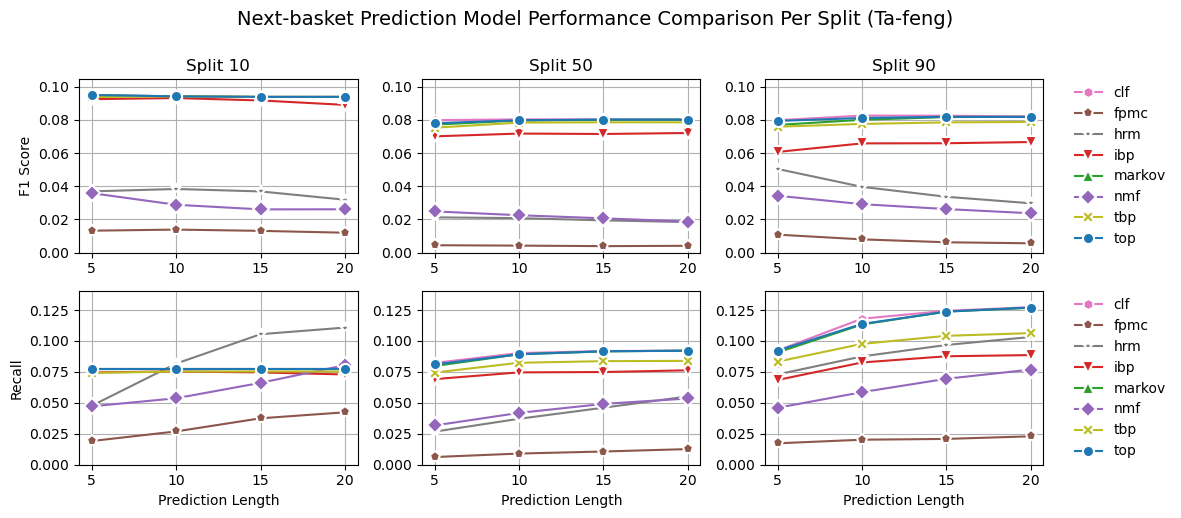

In [19]:
create_comparison_plots(
    csv_path='agg_nbp_scores_tafeng.csv',
    metrics=['mean_f1_score', 'mean_recall'],
    models_to_plot=['top', 'last', 'markov', 'ibp', 'nmf', 'fpmc','clf', 'hrm', 'tbp',],
    split_types=['split_10', 'split_50', 'split_90'],
    pred_lengths=[5, 10, 15, 20]
    # save_path='model_comparison_short_pred.png'
)

# # Example with longer prediction lengths
# create_comparison_plots(
#     csv_path='agg_nbp_scores.csv',
#     metrics=['mean_f1_score', 'mean_precision', 'mean_recall'],
#     models_to_plot=['top', 'last', 'markov', 'ibp'],
#     split_types=['split_50'],
#     pred_lengths=[5, 10, 15, 20],  # Only show these prediction lengths
#     save_path='baseline_comparison_long_pred.png'
# )

### NBP Benchmarking COOP

In [20]:
def plot_metrics(df: pd.DataFrame, day: int, metrics: list = None, metric_titles: dict = None, 
                model_colors: dict = None, save_path: str = None, line_alpha: float = 0.7,
                label_fontsize: int = 12, title_fontsize: int = 14, legend_fontsize: int = 12):
    """
    Create plots for different metrics across split types for a specific day.
    
    Args:
        df: DataFrame with the aggregated results
        day: Which day to plot (0, 1, or 2)
        metrics: List of metric column names to plot (e.g., ['avg_f1_score', 'avg_precision'])
                If None, defaults to ['avg_f1_score', 'avg_recall']
        metric_titles: Dictionary mapping metric names to display titles
                      If None, uses capitalized metric names without 'avg_' prefix
        model_colors: Dictionary mapping model names to colors
        save_path: If provided, save the plot to this path instead of displaying
        line_alpha: Transparency level for lines and markers (0-1, default: 0.7)
        label_fontsize: Font size for axis labels and tick labels (default: 12)
        title_fontsize: Font size for subplot titles and main title (default: 14)
        legend_fontsize: Font size for legend text (default: 12)
    """
    # Set default metrics if none provided
    if metrics is None:
        metrics = ['avg_f1_score', 'avg_recall']
    
    # Create default metric titles if none provided
    if metric_titles is None:
        metric_titles = {}
        for metric in metrics:
            # Remove 'avg_' prefix and convert to title case
            title = metric.replace('avg_', '').replace('_', ' ').title()
            metric_titles[metric] = title
    
    # If no color mapping provided, use default colors
    if model_colors is None:
        model_colors = {
            'top': '#1f77b4',     # blue
            'last': '#ff7f0e',    # orange
            'mc': '#2ca02c',  # green
            'ibp': '#d62728',     # red
            'nmf': '#9467bd',     # purple
            'fpmc': '#8c564b',    # brown
            'clf': '#e377c2',     # pink
            'hrm': '#7f7f7f',     # gray
            'tbp': '#bcbd22',     # yellow-green
            'xmt': '#17becf',     # cyan
            'tars_xmt_final_sum': '#000000'    # black
        }
    
    # Define distinct markers for each model
    markers = {
        'top': 'o',           # circle
        'last': 's',         # square
        'mc': '^',       # triangle up
        'ibp': 'v',          # triangle down
        'nmf': 'D',          # diamond
        'fpmc': 'p',         # pentagon
        'clf': 'h',          # hexagon
        'hrm': '*',          # star
        'tbp': 'X',          # x filled
        'xmt': 'P',          # plus filled
        'tars_xmt_final_sum': '8'  # octagon
    }
    
    # Filter data for the specified day
    df = df[df['max_days'] == day].copy()
    
    # Get unique split types and sort them
    split_types = sorted(df['split_type'].unique())
    
    # Get unique models and sort them alphabetically
    models = sorted(df['model_name'].unique())
    
    # Calculate maximum values for each metric across all splits
    max_values = {metric: df[metric].max() * 1.1 for metric in metrics}  # Add 10% padding
    
    # Calculate the number of columns needed
    n_cols = len(split_types)
    
    # Create figure
    fig = plt.figure(figsize=(5 * n_cols + 2, 4 * len(metrics)))
    
    # Add main title to the figure
    fig.suptitle(f'Average scores for predicted baskets (max_days=2)', 
                fontsize=title_fontsize, y=0.95)
    
    # Create a grid of subplots
    gs = fig.add_gridspec(len(metrics), n_cols)
    
    # Create axes for the plots
    axes = [[fig.add_subplot(gs[i, j]) for j in range(n_cols)] for i in range(len(metrics))]
    
    # Store legend handles and labels
    legend_handles = []
    legend_labels = []
    first_plot = True
    
    # Plot data
    for i, metric in enumerate(metrics):
        for j, split_type in enumerate(split_types):
            ax = axes[i][j]
            
            # Filter the dataframe by split type
            split_df = df[df['split_type'] == split_type]
            
            # Calculate average performance for z-order
            model_performance = {}
            for model in models:
                model_df = split_df[split_df['model_name'] == model]
                if not model_df.empty:
                    model_performance[model] = model_df[metric].mean()
            
            # Sort models by performance for z-order
            sorted_models = sorted(model_performance.items(), key=lambda x: x[1])
            
            for model, perf in sorted_models:
                model_df = split_df[split_df['model_name'] == model]
                if not model_df.empty:
                    color = model_colors.get(model, 'black')
                    marker = markers.get(model, 'o')
                    line = ax.plot(model_df['pred_length'], model_df[metric], 
                                 marker=marker, 
                                 label=model, 
                                 color=color,
                                 alpha=line_alpha,
                                 markersize=8, 
                                 markeredgewidth=1.5,
                                 markeredgecolor=color,
                                 markerfacecolor='white')
                    
                    # Store legend info only from first subplot
                    if first_plot and model not in legend_labels:
                        legend_handles.append(line[0])
                        legend_labels.append(model)
            
            if first_plot:
                first_plot = False
            
            # Only show x-label on bottom row
            if i == len(metrics) - 1:
                ax.set_xlabel('Prediction Length', fontsize=label_fontsize)
            
            # Only show split type on top row
            if i == 0:
                ax.set_title(f'Split {split_type}', fontsize=title_fontsize)
            
            ax.grid(True, alpha=0.3)
            
            # Set specific tick marks as integers
            unique_pred_lengths = sorted(split_df['pred_length'].unique())
            ax.set_xticks(unique_pred_lengths)
            ax.set_xticklabels([int(x) if pd.notnull(x) else 'N/A' for x in unique_pred_lengths],
                             fontsize=label_fontsize)
            ax.tick_params(axis='y', labelsize=label_fontsize)
            
            # Add y-label only to first column
            if j == 0:
                ax.set_ylabel(metric_titles[metric], fontsize=label_fontsize)
                
            # Set y-axis limits from 0 to max value plus padding
            ax.set_ylim(0, max_values[metric])
    
    # Sort legend items alphabetically
    legend_items = sorted(zip(legend_labels, legend_handles), key=lambda x: x[0])
    legend_labels, legend_handles = zip(*legend_items)
    
    # Add single legend on the right side
    fig.legend(legend_handles, legend_labels,
              title='Models',
              bbox_to_anchor=(1.0, 0.5),
              loc='center left',
              borderaxespad=0,
              fontsize=legend_fontsize,
              title_fontsize=title_fontsize)
    
    # Adjust layout
    plt.subplots_adjust(right=0.85)
    plt.tight_layout(rect=[0, 0, 1.0, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=900)
        plt.close()
    else:
        plt.show()

In [21]:
# Read the aggregated results
df = pd.read_csv('agg_results_nbp_coop.csv')

filtered_df = df[
    (df['pred_length'].isin([5, 10, 15, 20])) & 
    (df['split_type'].isin([30, 70]))
].sort_values(by=['model_name', 'pred_length', 'split_type']).reset_index(drop=True)

# Create plots for each day with custom line width
# plot_metrics(filtered_df, day=2,
#             metrics=['avg_f1_score', 'avg_precision', 'avg_recall', 'avg_hit_score'],
#             metric_titles={
#                 'avg_f1_score': 'F1 Score',
#                 'avg_precision': 'Precision',
#                 'avg_recall': 'Recall',
#                 'avg_hit_score': 'Hit Rate'
#             })

filtered_df['model_name'] = filtered_df['model_name'].replace('markov', 'mc')

# plot_metrics(filtered_df, day=2
#              , metrics=['avg_f1_score', 'avg_recall']
#              , metric_titles={
#                 'avg_f1_score': 'F1 Score',
#                 'avg_recall': 'Recall',
#                 }
#              , save_path='experiment_2_fib_results_1.png'
#              , line_alpha = 0.6)


plot_metrics(filtered_df
             , day=2
             , metrics=['avg_f1_score', 'avg_recall']
             , metric_titles={
                'avg_f1_score': 'F1 Score',
                'avg_recall': 'Recall',
                }
             , label_fontsize=14  # Larger axis labels and tick labels
             , title_fontsize=16  # Larger titles
             , legend_fontsize=12 # Keep legend size moderate
             , save_path='experiment_2_fib_results_1.png'
             , line_alpha=0.6)       # change transparency